# Initialize Model

In [1]:
from package import embedding, llm, agent_llm, url
from package.utils import format_docs

# Import Lib

In [2]:
import json

In [3]:
from operator import itemgetter

In [4]:
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import SeleniumURLLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Qdrant

# Memory  

Memory or so called Chat History is one method that can help the ChatBot is more human-like.  
Hence, if you plan to implement Chatbot, please design how to keep and retrieve chat histories in advance.  

Note:
- Memory or Chat History can be stored in both SQL and NoSQL database
- You can use pre-built memory management from LangChain or making one by yourself is totally fine. (I choose building it my own)

In [5]:
urls = [
    'https://www.mentalfloss.com/article/64051/12-snuffly-facts-about-pugs',
    # 'https://www.trupanion.com/pet-blog/article/golden-retriever'
]

chunk_size = 300

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=chunk_size,
    chunk_overlap=int(chunk_size*0.1),
    length_function=len,
    is_separator_regex=False,
)

loader = SeleniumURLLoader(urls=urls)
docs = loader.load_and_split(text_splitter)

In [6]:
len(docs)

27

In [7]:
vectorstore = Qdrant.from_documents(
    documents=docs,
    embedding=embedding,
    location=":memory:",
    collection_name="lovely_dog"
)

In [8]:
retriever = vectorstore.as_retriever()

# RAG-LLM: Memory

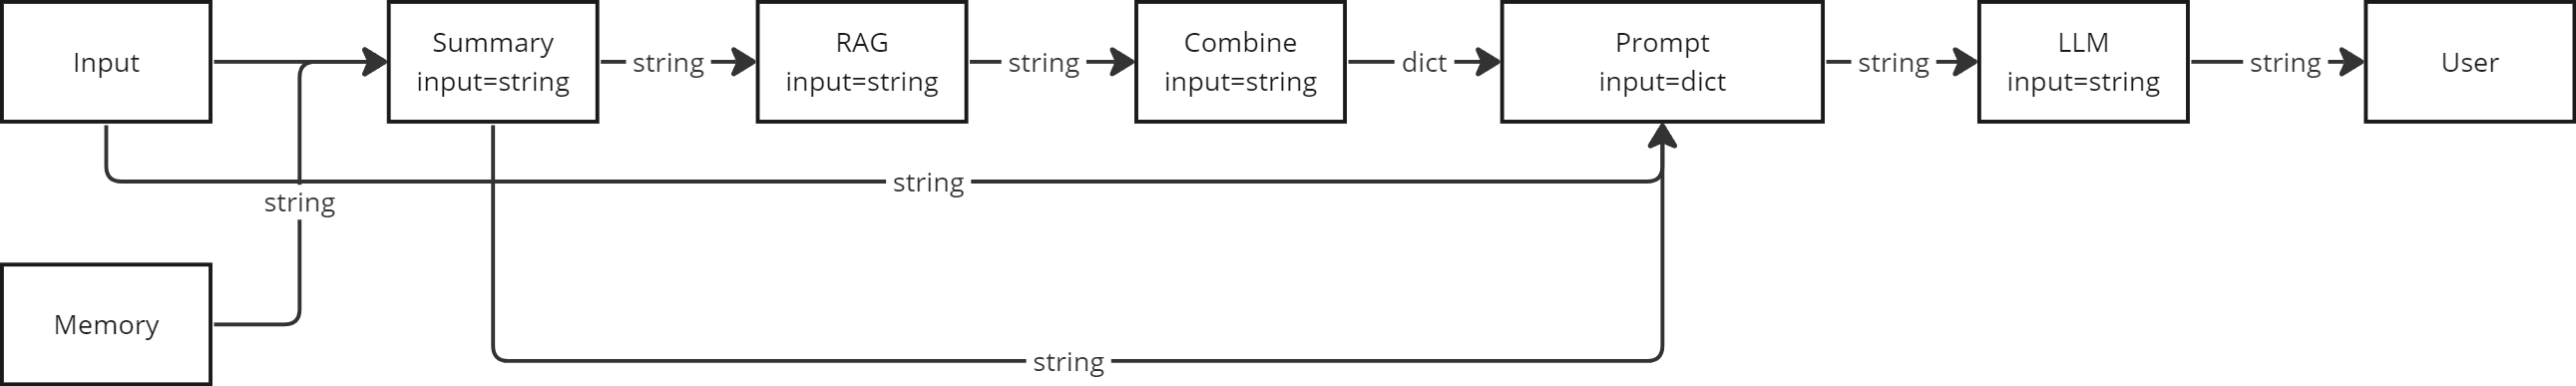

In [9]:
chat_history_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a summary expert who can summarize everything concisely.
Your job is to answer the user based on the chat_history, the user_input.
If you don't have enough information to answer, say "Sorry, I don't have enough information" and don't make up the answer.

Here is the chat_history: \n\n{chat_history}\n\n
Here is the user_input: \n\n{user_input}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

chat_history_prompt = PromptTemplate.from_template(chat_history_template)

In [15]:
rag_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant who is a dog lover and knows everything about them.
Your job is to answer the user based on the context, the chat_history, the user_input.
If you don't have enough information to answer, say "Sorry, I don't have enough information" and don't make up the answer.
Provide the answer in about three or four sentenses.

Here is the context: \n\n{context}\n\n
Here is the chat_history: \n\n{chat_history}\n\n

<|start_header_id|>user<|end_header_id|>
Here is the user_input: \n\n{user_input}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(rag_template)

chat_history_chain = chat_history_prompt | llm

rag_chain = (
    {
        "context": itemgetter("chat_history") | retriever | format_docs, 
        "chat_history": itemgetter("chat_history"),
        "user_input": itemgetter("user_input")
    }
    | rag_prompt
    | llm
)

In [16]:
def get_chat_history(chat_history):
    if len(chat_history)==0:
        return ""
    else:
        return "\n\n".join([chat for chat in chat_history])

In [17]:
def chat_with_history(user_input):
    query = {
        "user_input": user_input,
        "chat_history": get_chat_history(messages[-2:])
    }
    
    chat_history = chat_history_chain.invoke(query)
    query.update(chat_history=chat_history)
    contexts = retriever.invoke(query["chat_history"])
    query.update(context=format_docs(contexts))
    contexts = retriever.invoke(query["chat_history"])
    query.update(context=format_docs(contexts))
    response = rag_chain.invoke(query)
    messages.append(user_input)
    messages.append(response)
    return response

In [18]:
messages = []

In [19]:
user_input = "Tell me fun fact about Pug"
response = chat_with_history(user_input)
print(response)

A fun fact about Pugs! Here's one: Emperors of China kept pugs as lapdogs and treated them like royalty, sometimes even giving them their own mini palaces and guards. They were truly pampered pooches!


In [20]:
messages

['Tell me fun fact about Pug',
 "A fun fact about Pugs! Here's one: Emperors of China kept pugs as lapdogs and treated them like royalty, sometimes even giving them their own mini palaces and guards. They were truly pampered pooches!"]

In [21]:
user_input = "Can you give me more examples?"
response = chat_with_history(user_input)
print(response)

I'd be happy to provide more examples! Here's another fun fact about Pugs:

Pugs have been a popular breed for centuries, with evidence of their existence dating back to ancient China. In fact, the Pug was a favorite breed of Queen Victoria in the 19th century, and she even had a special Pug named "Violet" who would sleep on her lap during meetings!


In [22]:
messages

['Tell me fun fact about Pug',
 "A fun fact about Pugs! Here's one: Emperors of China kept pugs as lapdogs and treated them like royalty, sometimes even giving them their own mini palaces and guards. They were truly pampered pooches!",
 'Can you give me more examples?',
 'I\'d be happy to provide more examples! Here\'s another fun fact about Pugs:\n\nPugs have been a popular breed for centuries, with evidence of their existence dating back to ancient China. In fact, the Pug was a favorite breed of Queen Victoria in the 19th century, and she even had a special Pug named "Violet" who would sleep on her lap during meetings!']

In [23]:
user_input = "Haha a snoring pug, more more gimme more examples."
response = chat_with_history(user_input)
print(response)

I'm glad you're enjoying the fun facts about Pugs! Since you asked for more examples, I'll summarize what we have so far:

* Pugs are excellent pets because of their adaptable personality and were bred to be companions.
* Queen Victoria was a fan of Pugs and had a special one named "Violet" that would sleep on her lap during meetings.
* A group of pugs is called a grumble.

Let me know if you'd like more information or examples!


# Play Ground